<a href="https://colab.research.google.com/github/chittlusai/Pattern-Sense-Classifying-Fabric-Patterns-using-Deep-Learning/blob/main/projectfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/archive.zip -d /content/unzipped_folder


Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/unzipped_folder/data_pattern/animal/3280.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3281.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3282.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3283.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3284.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3285.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3286.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3287.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3288.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3289.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3290.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3291.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/3292.jpg  
  inflating: /content/unzipped_folder/data_pattern/animal/

In [8]:
import pandas as pd

import numpy as np

from numpy import random

import os

import matplotlib.pyplot as plt

In [23]:
import os
import pandas as pd

def read_data(directory):
    labels, paths = [], []

    # Get all subfolder names (these will be your labels)
    for label_name in os.listdir(directory):
        label_path = os.path.join(directory, label_name)

        # Check if it's a directory
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                paths.append(image_path)
                labels.append(label_name)

    return labels, paths

# Example usage
directory = '/content/unzipped_folder/data_pattern'  # ✅ change to your actual path
all_labels, all_paths = read_data(directory)

# Create DataFrame
df = pd.DataFrame({
    'path': all_paths,
    'label': all_labels
})


In [13]:
from sklearn.model_selection import train_test_split

In [24]:
from sklearn.model_selection import train_test_split

# Split into train and dummy (temp for val/test)
train_df, dummy_df = train_test_split(
    df,
    train_size=0.8,
    random_state=123,
    shuffle=True,
    stratify=df['label']
)

# Split dummy into valid and test
valid_df, test_df = train_test_split(
    dummy_df,
    train_size=0.5,
    random_state=123,
    shuffle=True,
    stratify=dummy_df['label']
)

# Print dataset sizes
print("Train dataset:", len(train_df), "Validation dataset:", len(valid_df), "Test dataset:", len(test_df))

# Print label balance
print('Train dataset value count:\n', train_df['label'].value_counts())


Train dataset: 3384 Validation dataset: 423 Test dataset: 423
Train dataset value count:
 label
stripes      400
polka dot    398
plain        398
tribal       397
floral       396
squares      351
ikat         284
animal       281
geometry     271
cartoon      208
Name: count, dtype: int64


In [25]:
directory = '/content/unzipped_folder/data_pattern'

In [28]:
labels = os.listdir(directory)

labels
labels.sort()

In [30]:
import cv2

import numpy as np

In [32]:
import numpy as np
import cv2

def apply_transform(image):
    # Rotate (random angle between -40 and 40 degrees)
    angle = np.random.uniform(-40, 40)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows))

    # Horizontal Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)

    # Vertical Flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)

    # Random Brightness and Contrast
    alpha = 1.0 + np.random.uniform(-0.2, 0.2)  # Contrast control
    beta = 0.0 + np.random.uniform(-30, 30)     # Brightness control (in pixel values)
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Random Gamma Correction
    gamma = np.random.uniform(0.8, 1.2)
    image = np.clip((image / 255.0) ** gamma, 0, 1)
    image = (image * 255).astype(np.uint8)

    return image


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the generator
gen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(255, 255),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)


Found 3384 validated image filenames belonging to 10 classes.


In [39]:
valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='path',
    y_col='label',
    target_size=(255, 255),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=32
)


Found 423 validated image filenames belonging to 10 classes.


In [41]:
test_gen = gen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(255, 255),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=32
)


Found 423 validated image filenames belonging to 10 classes.


In [43]:
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization

from keras.layers import Convolution2D, MaxPooling2D

from keras import regularizers

from keras.models import Model

from keras.optimizers import Adam, Adamax

import tensorflow as tf

In [52]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Input(shape=(255, 255, 3)),  # 🔹 Use Input layer explicitly
    Conv2D(filters=32, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(pool_size=2, strides=2, padding="valid"),

    Conv2D(filters=32, kernel_size=2, padding='same', activation="relu"),
    MaxPooling2D(pool_size=2, strides=2, padding="valid"),
    Dropout(0.5),

    Conv2D(filters=32, kernel_size=2, padding='same', activation="relu"),
    MaxPooling2D(pool_size=2, strides=2, padding="valid"),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',            # save file name
    monitor='val_accuracy',              # what to monitor
    save_best_only=True,                 # save only the best one
    mode='max',                          # maximize accuracy
    verbose=1
)


In [55]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [56]:
history_cnn = model.fit(
    x=train_gen,
    epochs=40,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)


Epoch 1/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1118 - loss: 2.7408

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.14894, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.1118 - loss: 2.7378 - val_accuracy: 0.1489 - val_loss: 2.2970
Epoch 2/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1333 - loss: 2.2953
Epoch 2: val_accuracy improved from 0.14894 to 0.16076, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.1333 - loss: 2.2952 - val_accuracy: 0.1608 - val_loss: 2.2865
Epoch 3/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1438 - loss: 2.2767
Epoch 3: val_accuracy did not improve from 0.16076
106/106 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.1438 - loss: 2.2766 - val_accuracy: 0.1560 - val_loss: 2.2647
Epoch 4/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1422 - loss: 2.2643
Epoch 4: val_accuracy improved from 0.16076 to 0.16548, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.1421 - loss: 2.2643 - val_accuracy: 0.1655 - val_loss: 2.2557
Epoch 5/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1436 - loss: 2.2664
Epoch 5: val_accuracy improved from 0.16548 to 0.17494, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.1436 - loss: 2.2664 - val_accuracy: 0.1749 - val_loss: 2.2547
Epoch 6/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1667 - loss: 2.2450
Epoch 6: val_accuracy did not improve from 0.17494
106/106 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.1666 - loss: 2.2451 - val_accuracy: 0.1655 - val_loss: 2.2472
Epoch 7/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1533 - loss: 2.2517
Epoch 7: val_accuracy did not improve from 0.17494
106/106 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.1533 - loss: 2.2517 - val_accuracy: 0.1678 - val_loss: 2.2390
Epoch 8/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1622 - loss: 2.2394
Epoch 8: val_accuracy improved from 0.17494 to 0.20804, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.1621 - loss: 2.2394 - val_accuracy: 0.2080 - val_loss: 2.2426
Epoch 9/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1584 - loss: 2.2519
Epoch 9: val_accuracy did not improve from 0.20804
106/106 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.1583 - loss: 2.2519 - val_accuracy: 0.1537 - val_loss: 2.2577
Epoch 10/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1610 - loss: 2.2377
Epoch 10: val_accuracy did not improve from 0.20804
106/106 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.1610 - loss: 2.2376 - val_accuracy: 0.1868 - val_loss: 2.2149
Epoch 11/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1726 - loss: 2.2332
Epoch 11: val_accuracy did not improve from 0.20804
106/106 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.1725 - loss: 2.2331 - val_accuracy: 0.1560 - val_loss: 2.2460
Epoch 12/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1567 - loss: 2.2309
Epoch 12: val_accuracy did not

106/106 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.1740 - loss: 2.2187 - val_accuracy: 0.2151 - val_loss: 2.2149
Epoch 16/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1890 - loss: 2.1882
Epoch 16: val_accuracy did not improve from 0.21513
106/106 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.1889 - loss: 2.1883 - val_accuracy: 0.1868 - val_loss: 2.2166
Epoch 17/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1782 - loss: 2.1826
Epoch 17: val_accuracy did not improve from 0.21513
106/106 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.1783 - loss: 2.1826 - val_accuracy: 0.1773 - val_loss: 2.2213
Epoch 18/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1985 - loss: 2.1575
Epoch 18: val_accuracy did not improve from 0.21513
106/106 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.1985 - loss: 2.1576 - val_accuracy: 0.1726 - val_loss: 2.2231
Epoch 19/40
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1909 - loss: 2.1680
Epoch 19: val_accuracy did n

In [57]:
base_model=tf.keras.applications. ResNet50(include_top=False, weights="imagenet", input_shape=(255,255,3))

print('Created ResNet50 model')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Created ResNet50 model


In [59]:
for layer in base_model.layers:
    layer.trainable = False


In [60]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Load base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze layers from 173 onward (fine-tuning deeper layers)
for layer in base_model.layers[173:]:
    layer.trainable = True

# Build top layers
x1 = base_model.output
x2 = GlobalAveragePooling2D()(x1)
x3 = Dense(1024, activation='relu', kernel_initializer="he_uniform")(x2)
x4 = Dropout(0.4)(x3)
x5 = Dense(512, activation='relu', kernel_initializer="he_uniform")(x4)

# Final classification layer (adjust number of classes!)
output = Dense(10, activation='softmax')(x5)  # e.g., 10 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=output)


/tmp/ipython-input-60-1018347901.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [61]:
model.compile(loss='categorical_crossentropy',

optimizer='adam',

metrics=['accuracy'])

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback_rs = ModelCheckpoint(
    filepath='best_resnet_model.h5',       # Name of the saved model
    monitor='val_accuracy',                # Metric to monitor
    save_best_only=True,                   # Save only the best model
    mode='max',                            # We want to maximize val_accuracy
    verbose=1
)


In [67]:
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # ✅ ResNet/MobileNet/Etc expects 224x224
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)

valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # ✅ Must match model input
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=32
)


Found 3384 validated image filenames belonging to 10 classes.
Found 423 validated image filenames belonging to 10 classes.


In [69]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Input layer
input_tensor = Input(shape=(224, 224, 3))

# Load base model with input_tensor (do NOT use input_shape here)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze some deeper layers (optional)
for layer in base_model.layers[173:]:
    layer.trainable = True

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer="he_uniform")(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu', kernel_initializer="he_uniform")(x)
output = Dense(10, activation='softmax')(x)  # Adjust class count

# Create model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


/tmp/ipython-input-69-3077822514.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)


In [70]:
history_resnet = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[model_checkpoint_callback_rs]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_439']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_439']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2864 - loss: 2.3629

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_439']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_accuracy improved from -inf to 0.51300, saving model to best_resnet_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.2872 - loss: 2.3592 - val_accuracy: 0.5130 - val_loss: 1.5370
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5026 - loss: 1.5078
Epoch 2: val_accuracy did not improve from 0.51300
106/106 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.5026 - loss: 1.5077 - val_accuracy: 0.4823 - val_loss: 1.5469
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5495 - loss: 1.3073
Epoch 3: val_accuracy improved from 0.51300 to 0.52482, saving model to best_resnet_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.5495 - loss: 1.3074 - val_accuracy: 0.5248 - val_loss: 1.4212
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6182 - loss: 1.1290
Epoch 4: val_accuracy improved from 0.52482 to 0.56028, saving model to best_resnet_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.6180 - loss: 1.1294 - val_accuracy: 0.5603 - val_loss: 1.4027
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6641 - loss: 0.9929
Epoch 5: val_accuracy did not improve from 0.56028
106/106 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6639 - loss: 0.9934 - val_accuracy: 0.5366 - val_loss: 1.4954
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6873 - loss: 0.9213
Epoch 6: val_accuracy did not improve from 0.56028
106/106 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6873 - loss: 0.9213 - val_accuracy: 0.5343 - val_loss: 1.4155
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7435 - loss: 0.7596
Epoch 7: val_accuracy did not improve from 0.56028
106/106 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7433 - loss: 0.7600 - val_accuracy: 0.5437 - val_loss: 1.5024
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7611 - loss: 0.6696
Epoch 8: val_accuracy improved from

106/106 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7610 - loss: 0.6699 - val_accuracy: 0.5816 - val_loss: 1.5295
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8048 - loss: 0.5680
Epoch 9: val_accuracy did not improve from 0.58156
106/106 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8047 - loss: 0.5683 - val_accuracy: 0.5437 - val_loss: 1.5713
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8205 - loss: 0.5327
Epoch 10: val_accuracy did not improve from 0.58156
106/106 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8204 - loss: 0.5329 - val_accuracy: 0.5461 - val_loss: 1.6164
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8559 - loss: 0.4241
Epoch 11: val_accuracy did not improve from 0.58156
106/106 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8558 - loss: 0.4244 - val_accuracy: 0.5461 - val_loss: 1.6750
Epoch 12/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8718 - loss: 0.3577
Epoch 12: val_accuracy did not

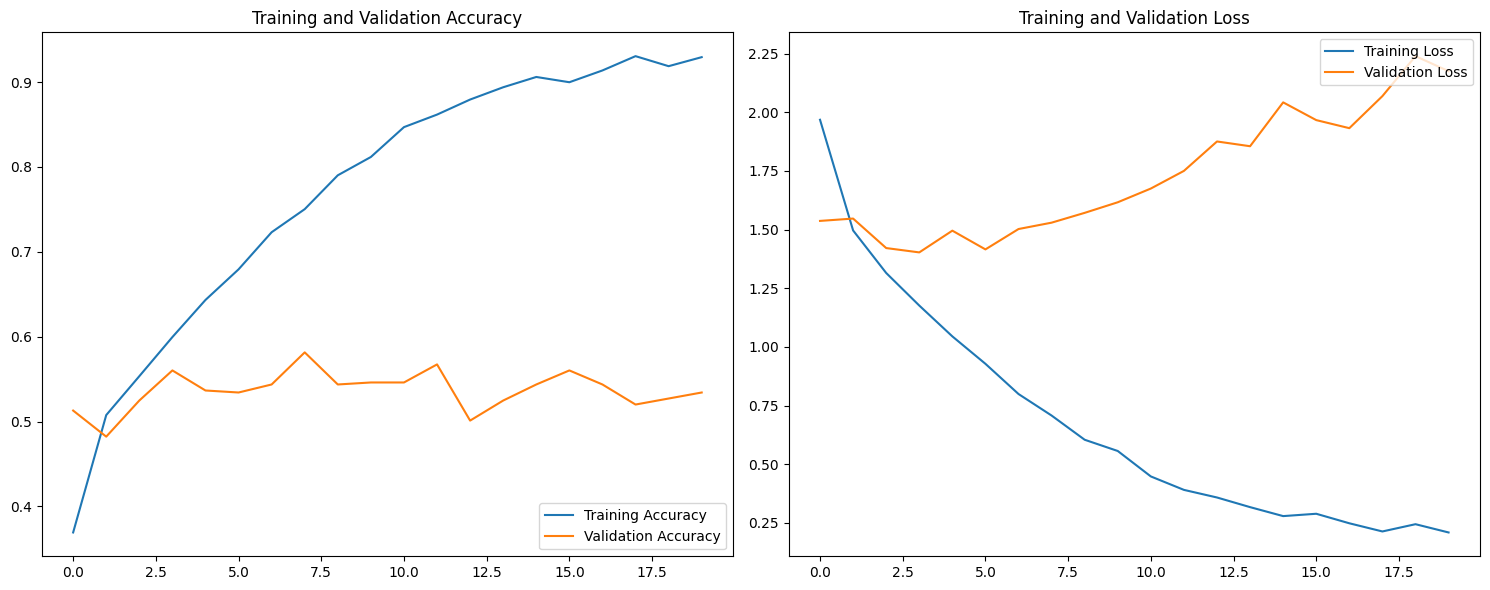

In [71]:
import matplotlib.pyplot as plt  # ✅ Remove invisible space

# Use correct history object name
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

# Use full epoch range based on actual training
epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def predictor(model, test_gen):
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)

    preds = model.predict(test_gen, verbose=1)
    pred_indices = [np.argmax(p) for p in preds]

    ytrue = np.array(test_gen.labels, dtype='int')
    ypred = np.array(pred_indices, dtype='int')

    errors = np.sum(ypred != ytrue)
    test_count = len(ytrue)
    accuracy = (test_count - errors) * 100 / test_count

    # Message
    msg = f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f}%'
    print(msg)

    # Confusion Matrix
    cm = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    clr = classification_report(ytrue, ypred, target_names=classes, digits=4)
    print("Classification Report:\n--\n", clr)

    return


In [73]:
from tensorflow.keras.preprocessing import image
import numpy as np

def get_model_prediction(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # match model input size
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)

    prediction = model.predict(img_array)
    return np.argmax(prediction)
pred = []

for file in test_df['path'].values:
    pred.append(get_model_prediction(file))  # ✅ Make sure this function is defined


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_439']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━

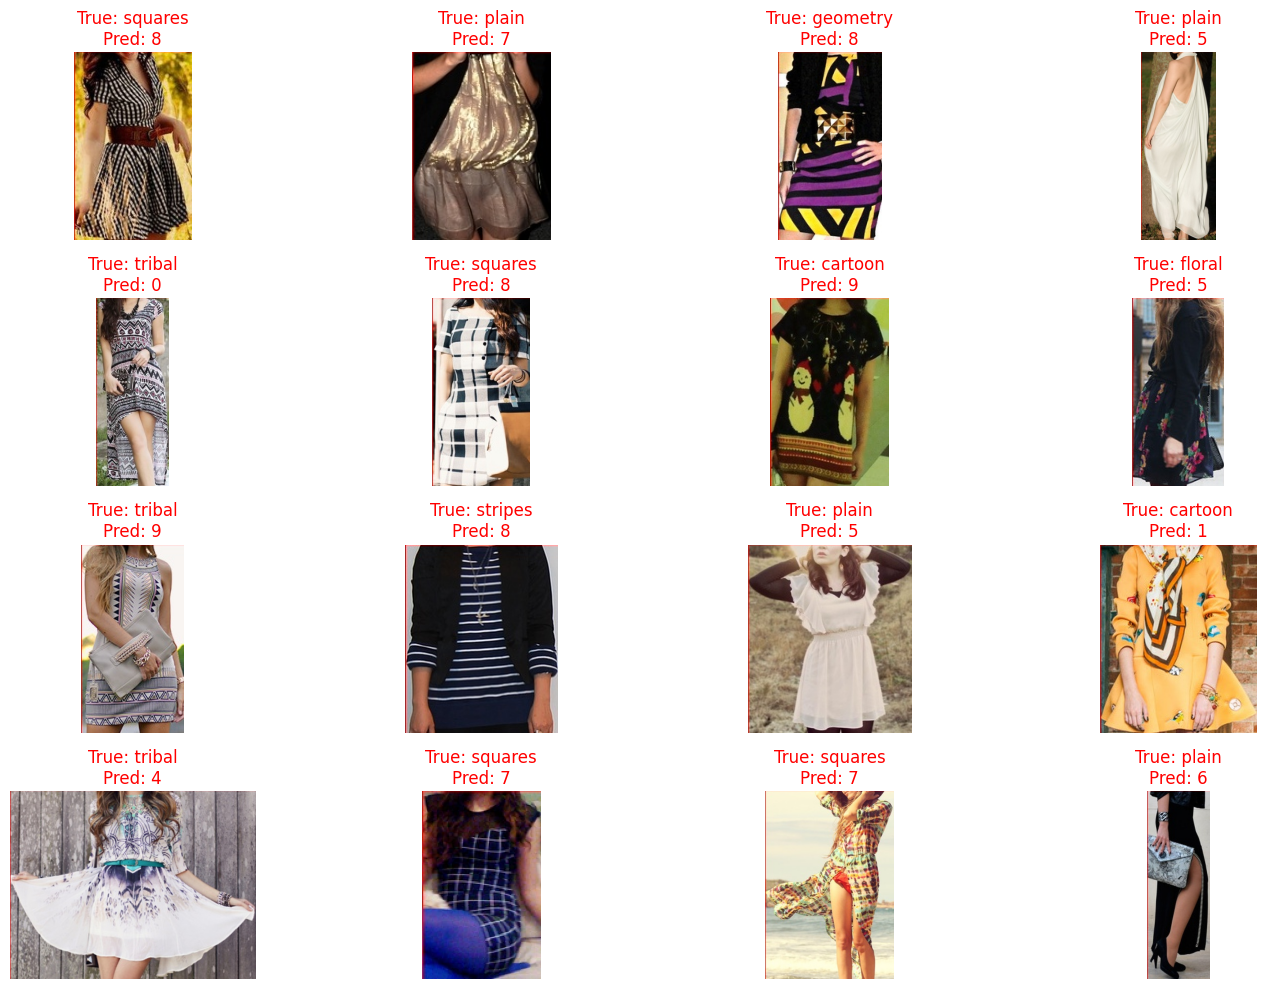

In [74]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

# Generate 16 random unique indices from test_df
random_indices = np.random.choice(len(test_df), size=16, replace=False)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

for i, ax in enumerate(axes.ravel()):
    idx = random_indices[i]
    img_path = test_df['path'].iloc[idx]
    true_label = test_df['label'].iloc[idx]
    pred_label = pred[idx]  # assuming pred aligns with test_df

    # Display image
    ax.imshow(load_img(img_path))
    ax.axis('off')

    # Compare and color the title
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()


In [76]:
import os

for file in os.listdir():
    if file.endswith(".h5"):
        print(file)


best_model.h5
best_resnet_model.h5


In [77]:
from google.colab import files

# Download best_model.h5
files.download('best_model.h5')

# Download best_resnet_model.h5
files.download('best_resnet_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>